In [1]:
from utils import *
import utils

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
GAME = 'CartPole-v1'
env = gym.make(GAME)
S, A = env.observation_space.shape[0], env.action_space.n
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box(4,)
Discrete(2)
(-inf, inf)


In [3]:
class Model(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(50, 'relu')
        self.W2 = tf.keras.layers.Dense(50, 'relu')
        self.W3 = tf.keras.layers.Dense(A)
        self.build((None,S))
    
    def call(self, x):
        x = self.W1(x)
        x = self.W2(x)
        return self.W3(x)
    
create_nn = lambda S,A: Model(S,A)

In [4]:
def epsilon_greedy(q, epsilon): # [1,A], []
    ''' q values [1,A] -> [] action '''
    if np.random.rand() < epsilon: return np.random.choice(q.shape[1])
    else: return np.squeeze(np.argmax(q, axis=-1))

In [5]:
class Agent():
    def __init__(self, num_states, num_actions, lr, gamma=0.99):
        self.S, self.A = num_states, num_actions
        self.optimizer = tf.optimizers.Adam(lr)
        self.y = gamma
        self.Qnn = create_nn(self.S, self.A) # Q online network
        self.Tnn = create_nn(self.S, self.A) # Target network
        self.Tnn.set_weights( self.Qnn.get_weights() )
        self.batch_size = 64 # batch size
        self.swap_iters = 100 # if iter > this: swap/copy networks
        self._step = 1 # step count to construct epsilon and swap networks
        self.step2epsilon = create_epsilon_fn([(1.0, 0, 10000)], min_e=0.05) # from 1 to 0 in 10k steps
        self.step2epsilon = lambda x: 0.1
        self.D = deque(maxlen=2000) # experience replay buffer
        # calculate moving std + mean using batch normalization
        self.batch_norm = tf.keras.layers.BatchNormalization(momentum=0.95, axis=0, scale=False, center=False)
        # usage: self.bn(x, trainable=True/False), where x.shape = [b,X]
        # if trainable==False: (x - mean) / std, where mean, std are moving avg got when using trainable==True
        # if True: (x - x.mean(axis=-1) / x.std(axis=-1) # ([b,X] -[b]) / [b]
    
    def first_step(self, s, sdict): # [S]
        a = np.random.randint(self.A) # [] (random move)
        self.s, self.a = s, a # save prev state + action + q value
        # init plot values if not inited
        for a in range(self.A):
            sdict[f'action{a}'] += 0
            sdict[f'Qaction{a}'] += 0
        sdict['epsilon'] += 0
        sdict['loss'] += 0
        return a
        
    def step(self, r, s, sdict): # [], [S]
        # append tuple to experience replay
        self.D.append([self.s, self.a, r, s, False]) # s, a, r, s', done(bool)
        if len(self.D) < self.batch_size: loss = 0
        else: loss = self.update_weights(self.batch_size, sdict)
        sdict['loss'] += float(loss)
        # copy Q network to T network
        if self._step % self.swap_iters == 0:
            self.Tnn.set_weights( self.Qnn.get_weights() )
        # update other vars
        epsilon = self.step2epsilon(self._step)
        sdict['epsilon'] += epsilon
        self._step += 1
        # select action from Q network
        q = self.Qnn(s[None,:]) # [1,A]
        a = epsilon_greedy(q, epsilon) # []
        for a_ in range(self.A): sdict[f'Qaction{a_}'] += float(q[0,a_])
        sdict[f'action{a}'] += 1
        # remember last state + action
        self.s, self.a = s, a
        return a
    
    def update_weights(self, b, sdict): # batch size
        # select batch from experience replay
        B = random.sample(self.D, b) # random batch from experience replay
        S,A,R,Sn,Done = [np.squeeze(np_map(lambda x: x[j], B)) for j in range(5)] # all w/ shape [b] or [b,X]
        Done, A = Done.astype(bool), A.astype(int) # [b], [b]
        Q = self.Tnn(Sn) # [1,A]
        Qa_hat = R + ~Done * self.y * np.max(Q, axis=-1) # [b]
        # train nn for 1 epoch
        with tf.GradientTape() as tape:
            Q = self.Qnn(S) # [b,A]
            Qa = pick_action_values(values=Q, actions=A) # [b]
            each_loss = tf.reduce_sum( (Qa-Qa_hat)**2 , axis=-1 ) # [b]
            loss = tf.reduce_mean(each_loss) # avg of all examples
        # calc + update gradients
        nn_vars = self.Qnn.trainable_variables
        grads = tape.gradient(loss, nn_vars)
        self.optimizer.apply_gradients(zip(grads, nn_vars))
        return loss
    
    def last_step(self, r, sdict):
        self.D.append([self.s, self.a, r, self.s, True]) # s, a, r, s', done

In [6]:
agent_fn = lambda S,A,env_fn=None: Agent(num_states=S, num_actions=A, lr=1e-3, gamma=0.99)

In [7]:
# test_agent_on_simple_games(agent_fn, 'DQN', game_dict={'CartPole-v1':500})

In [8]:
d = pd.DataFrame()
agent = agent_fn(S,A)
exp = Experiment(env, agent)

In [9]:
df = exp.run(200, 1, name='')
d = d.append(df)

KeyboardInterrupt: 

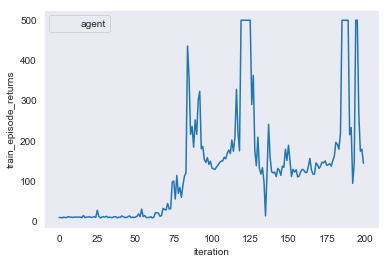

In [28]:
plot_df(df)

In [ ]:
d = d.append(pd.DataFrame(exp.D))

In [ ]:
exp.show_play(10000)

In [ ]:
df = exp.run(100, 1, name='')
d = d.append(df)

In [ ]:
d = pd.DataFrame(exp.D)

In [ ]:
ax = plot_df(df, y=['Qaction0/s', 'Qaction1/s', 'reward/e'], confidence=68)

In [ ]:
# df = exp.run(1000, 1, name='')
# d = d.append(df)

In [ ]:
df = load_my_benchmark('Pong-ram-v4')
plot_df(df, y='reward/e')
# df['epsilon/s']

In [ ]:
df = load_atari_benchmark('Pong')
df = df.loc[ df['iteration'] < 15 ]
plot_df(df)